In [1]:
import os
import json
import torch
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random

KeyboardInterrupt: 

In [13]:
class ChessDataset(Dataset):
    def __init__(self, json_folder, image_folder, transform=None):
        self.json_folder = json_folder
        self.image_folder = image_folder
        self.transform = transform
        
        # Sort JSON files numerically to match image IDs
        self.json_files = sorted(
        [f for f in os.listdir(json_folder) if f.endswith(".json")], 
        key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else float('inf')
        )

        
    def __len__(self):
        return len(self.json_files)
    
    def __getitem__(self, idx):
        json_file = self.json_files[idx]
        
        with open(os.path.join(self.json_folder, json_file), "r") as f:
            metadata = json.load(f)
        
        image_path = os.path.join(self.image_folder, f"{metadata['id']}.png")
        
        # Load image using PIL
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        return image, metadata  

class RandomApplyTransform:
    """Applies a given transform with a specified probability."""
    def __init__(self, transform, p=0.2):
        self.transform = transform
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:  # Apply transform with probability p
            return self.transform(img)
        return img

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224

    # Apply each transformation with 20% probability
    RandomApplyTransform(transforms.RandomHorizontalFlip(p=1.0), p=0.2),  
    RandomApplyTransform(transforms.RandomRotation(degrees=10), p=0.2),
    RandomApplyTransform(transforms.RandomResizedCrop(224, scale=(0.8, 1.2)), p=0.2),
    RandomApplyTransform(transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), p=0.2),
    RandomApplyTransform(transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), p=0.2),

    # Convert image to tensor
    transforms.ToTensor(),

    # Normalize (using ImageNet mean & std, adjust if needed)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# Custom collate function
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    metadata = [item[1] for item in batch]
    images = torch.stack(images, dim=0)  # Stack images into a tensor
    return images, metadata



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch length: 64


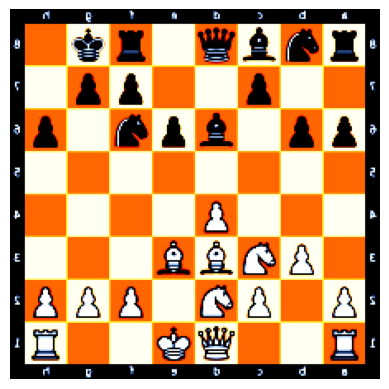

Label: {'id': 15364, 'State': {'Fen notation': 'rnbq1rk1/2p2pp1/pp1bpn1p/8/3P4/1PNBB3/P1PN1PPP/R2QK2R b KQ - 3 11', 'Pgn notation': '[Event "?"]\n[Site "?"]\n[Date "????.??.??"]\n[Round "?"]\n[White "?"]\n[Black "?"]\n[Result "*"]\n\n1. e4 d5 2. exd5 Nf6 3. Nf3 Qxd5 4. d4 Qd8 5. Bc4 e6 6. Nc3 Bd6 7. Bg5 h6 8. Be3 a6 9. b3 b6 10. Bd3 O-O 11. Nd2 *'}, 'player_to_play': True, 'Best_5_moves': ['d6b4', 'c8b7', 'b8c6', 'b8d7', 'a8a7']}


In [19]:
# Create Dataset 
dataset = ChessDataset(json_folder="output/json", image_folder="output/images", transform=transform)

# Create DataLoader
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, collate_fn= custom_collate_fn, pin_memory=False)

# Fetch a batch
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch length: {len(train_labels)}")

# Display an image
img = train_features[0].permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
plt.imshow(img)
plt.axis('off')
plt.show()
print(f"Label: {train_labels[0]}")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total samples in dataset: 20000
Sample metadata: {'id': 0, 'State': {'Fen notation': '3qk2r/1Qp1pb1p/4N1p1/p2P1p2/1n1bn3/6P1/PP2PPBP/RNB2RK1 b - - 1 15', 'Pgn notation': '[Event "?"]\n[Site "?"]\n[Date "????.??.??"]\n[Round "?"]\n[White "?"]\n[Black "?"]\n[Result "*"]\n\n1. d4 f5 2. Nh3 g6 3. c3 Bg7 4. g3 a5 5. Bg2 d5 6. O-O Na6 7. Qb3 Nf6 8. c4 Be6 9. Qxb7 Ne4 10. Nf4 Bf7 11. Qa7 Nb4 12. Qxa8 Kd7 13. Qb7 Ke8 14. cxd5 Bxd4 15. Ne6 *'}, 'player_to_play': True, 'Best_5_moves': ['f7e6', 'e4d6', 'd4f2', 'e8d7', 'e4c5']}


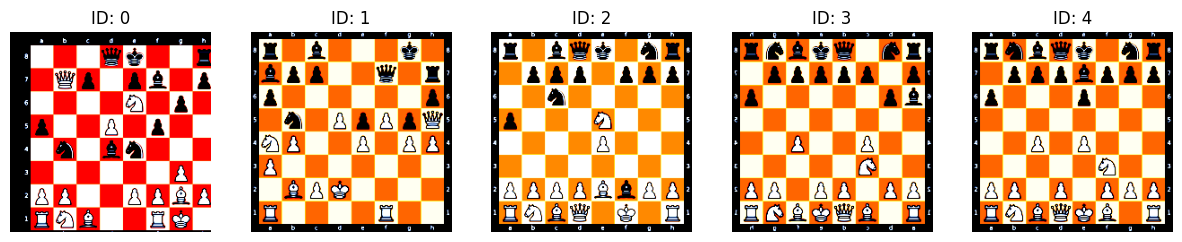

In [20]:
# Check the length of the dataset
print(f"Total samples in dataset: {len(dataset)}")

# Access a single sample
sample_image, sample_metadata = dataset[0]  # Change the index as needed
print(f"Sample metadata: {sample_metadata}")

# Function to display multiple images
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, metadata = dataset[i]
        axes[i].imshow(image.permute(1, 2, 0))
        axes[i].set_title(f"ID: {metadata['id']}")
        axes[i].axis('off')
    plt.show()

# Display multiple images
show_images(dataset, num_images=5)
